## Long Short-Term Memory (LSTM) Networks:

In this code, we first preprocess the data by selecting the desired columns, setting the Date column as the index, and normalizing the data using MinMaxScaler. We then split the data into training and testing sets. The create_sequences function is used to create input sequences and labels for the LSTM model.

Next, we build and train the LSTM model using the training data. We use the EarlyStopping callback to prevent overfitting by monitoring the validation loss. After training, we generate predictions for both the training and testing sets.

Finally, we inverse transform the predictions and actual values to their original scale using the MinMaxScaler. We plot the training and testing predictions along with the actual values to visualize the forecasted energy prices.

Please note that you may need to adjust the architecture, hyperparameters, and preprocessing steps based on your specific requirements and dataset characteristics.

# 4 Weely prediction with graphs

Training, predictions and graph with best model

In [ ]:
# Windows local host
#filepath = 'C:/Users/Alber/PHB009/PHB009/dataset/model/combined_data.csv'
# Google Colab
filepath = '/content/drive/MyDrive/PHB009/dataset/model/combined_data.csv'
save_to = '/content/drive/MyDrive/PHB009/dataset/model/LSTM.csv'

In [ ]:
import pandas as pd

# Read the data into a DataFrame (replace 'your_data.csv' with your actual file)
data_df = pd.read_csv(filepath, parse_dates=['Date'])

# Assuming 'data' is your DataFrame and 'columns_to_drop' is a list of column names to drop
columns_to_drop =  ['Open', 'High', 'Low', 'Close', 'BOMBEO', 'BRENT', 'CARBON', 'CICLOCOMBINADO', 'COGENERACION', 'EOLICA', 'HIDRAULICA', 'NUCLEAR', 'SOLAR', 'TTF']  # Replace with your column names
data_df.drop(columns=columns_to_drop, inplace=True)
data_df.fillna(method='ffill', inplace=True)
data_df.fillna(method='bfill', inplace=True)

# Read the CSV files into dataframes
impact_df = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/AggregatedImpactOpenAI.csv', parse_dates=['Date'])

# Convert 'Date' columns to datetime format
data_df['Date'] = pd.to_datetime(data_df['Date'])
impact_df['Date'] = pd.to_datetime(impact_df['Date'])

# Left join dataframes based on 'Date'
result_df = data_df.merge(impact_df, on='Date', how='left')

# Fill missing values with 0 for the 'df_impact' columns
impact_columns = ['Impact_long', 'Impact_short']
result_df[impact_columns] = result_df[impact_columns].fillna(0)

################################################################################
#         TESTING THE EFFECT OF REMOVING SHORT TERM IMPACT
#columns_to_drop =  ['Impact_short']
#result_df.drop(columns=columns_to_drop, inplace=True)
################################################################################

# Set 'Date' as the index of the dataframe
result_df.set_index('Date', inplace=True)

result_df

,Price,GasPrice,Demand,Non-renewable,Renewable,Renewable%,IBEX35,MIBGAS,OMIP,Impact_long,Impact_short
Date,,,,,,,,,,,
2018-01-01,25.575652,21.81,20545.034,13246.167,52707.752,79.916027,10079.099609,21.81,61.85,0.0,-0.10
2018-01-02,40.395000,22.51,18436.677,20002.151,63514.750,76.050176,10079.099609,22.51,61.85,0.0,-0.08
2018-01-03,45.659167,20.40,27336.476,13118.374,64639.179,83.129132,10116.000000,20.40,61.85,0.0,-0.06
2018-01-04,45.440833,19.01,24369.628,15972.084,75027.418,82.448163,10314.400391,19.01,61.85,0.0,-0.04
2018-01-05,44.158750,19.78,6050.885,13230.971,70900.792,84.273513,10411.400391,19.78,61.85,0.0,-0.03
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-28,85.040833,24.95,11943.874,8920.884,49018.014,84.602945,9191.100000,24.95,179.72,0.0,-0.30
2023-05-29,95.328750,26.05,11057.423,9343.901,64469.725,87.341225,9180.100000,26.05,179.72,0.0,-0.22
2023-05-30,93.355833,25.59,9792.152,8348.557,59350.614,87.668155,9167.500000,25.59,179.72,0.0,-0.16


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Initialize aggregation_functions dictionary
aggregation_functions = {}

for col in result_df.columns:
    if col == 'Price':
       aggregation_functions[col] = 'mean'
    elif col == 'Open':
        aggregation_functions[col] = 'first'
    elif col == 'High':
        aggregation_functions[col] = 'max'
    elif col == 'Low':
        aggregation_functions[col] = 'min'
    elif col == 'Close':
        aggregation_functions[col] = 'last'
    else:
        aggregation_functions[col] = 'mean'

# Resample and aggregate by 4-week intervals
data_4weeks = result_df.resample('4W-Mon', closed='right', label='right').agg(aggregation_functions)

# Recover 'Date' as a column and reset the index
data_4weeks.reset_index(inplace=True)

# Select the relevant columns for the LSTM model
columns = data_4weeks.columns.tolist()
lstm_data = data_4weeks[columns].copy()

# Set the 'Date' column as the index
lstm_data.set_index('Date', inplace=True)

# Define the date range for testing (2023-01-01 to 2023-06-01)
train_end_date = '2023-01-01'
train_data = lstm_data.loc[(lstm_data.index <= train_end_date)]

# Define the date range for testing (2023-01-01 to 2023-06-01)
test_start_date = '2022-01-24'
test_data = lstm_data.loc[(lstm_data.index >= test_start_date)]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 12  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse', run_eagerly=True)  # Add run_eagerly=True
    return model

# Create the KerasRegressor wrapper for GridSearchCV
best_model = create_model(units=100)
best_epochs = 20
best_batch_size = 32

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Prepare the data for LSTM testing
X_test, y_test = [], []
for i in range(len(test_data_scaled) - n_steps + 1):
    X_test.append(test_data_scaled[i:i + n_steps, 1:])  # Exclude the date and price columns
X_test = np.array(X_test)

# Make predictions using the trained LSTM model
forecast_scaled = best_model.predict(X_test)

# Reshape forecast_scaled to match the expected shape
n_samples = len(forecast_scaled)
forecast_reshaped = np.full((n_samples, n_features + 1), np.nan)
forecast_reshaped[:, 1] = forecast_scaled.flatten()

# Perform inverse scaling and extract the forecasted price
forecast = scaler.inverse_transform(forecast_reshaped)[:, 1]

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=test_start_date, periods=len(forecast), freq='4W-Mon')
forecast_index = forecast_index.shift(n_steps, freq='4W-Mon')  # Shift the index by n_steps 4-weeks
forecast_data = pd.DataFrame({'Date': forecast_index, 'Forecasted Price': forecast})


1/1 [==============================] - 0s 69ms/step


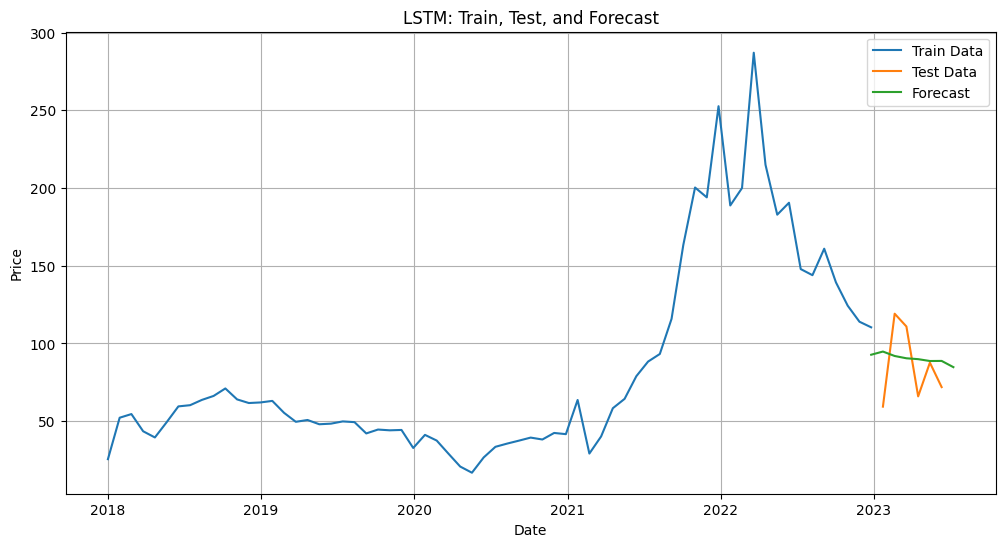

In [ ]:
import matplotlib.pyplot as plt

test_data_subset = test_data[test_data.index >= '2023-01-01']

# Convert the train and test data to Matplotlib format
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Data')
plt.plot(test_data_subset.index, test_data_subset['Price'], label='Test Data')
plt.plot(forecast_data['Date'], forecast_data['Forecasted Price'], label='Forecast')
plt.title('LSTM: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

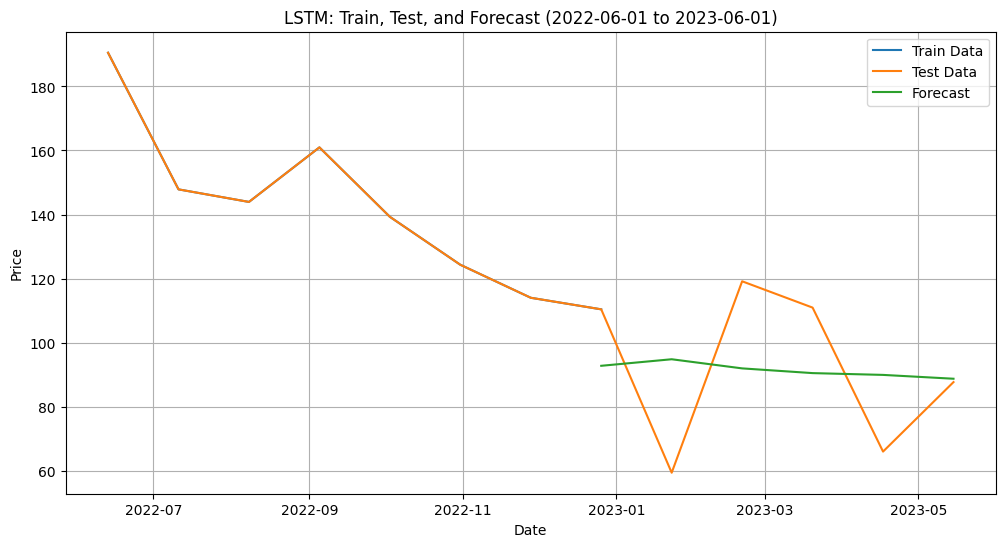

In [ ]:
# Filter data for the desired period
start_date = '2022-06-01'
end_date = '2023-06-01'
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_filtered.index, train_data_filtered['Price'], label='Train Data')
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Train, Test, and Forecast (2022-06-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

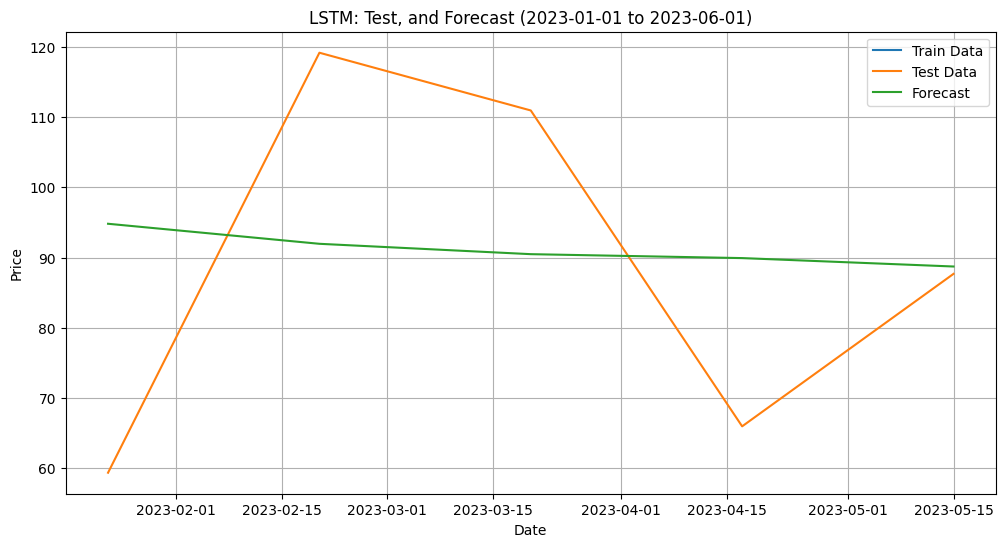

In [ ]:
# Filter data for the desired period
start_date = '2023-01-01'
end_date = '2023-06-01'
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_filtered.index, train_data_filtered['Price'], label='Train Data')
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Test, and Forecast (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Filter data for the desired period
start_date = '2023-01-01'
end_date = '2023-06-01'
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_filtered['Price'], forecast_filtered['Forecasted Price']))

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Root Mean Squared Error (RMSE): 24.44


In [ ]:
import pandas as pd

# Filter data for the desired period
start_date = '2023-01-01'
end_date = '2023-06-01'
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Merge the DataFrames and rename columns
result_df = pd.merge(test_data_filtered, forecast_filtered, how='inner', left_index=True, right_on='Date')
result_df = result_df.rename(columns={'Date_x': 'Date', 'Forecasted Price': 'Prediction'})

# Select 'Date', 'Price', and 'Prediction' columns
result_df = result_df[['Date', 'Price', 'Prediction']]

# Print the resulting DataFrame
print(result_df)

        Date       Price  Prediction
1 2023-01-23   59.369539   94.802358
2 2023-02-20  119.146205   91.950966
3 2023-03-20  110.927411   90.475688
4 2023-04-17   65.971711   89.916295
5 2023-05-15   87.670759   88.719160


In [ ]:
result_df[['Date','Price','Prediction']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/results/4WAILSTMResults.csv')

## Interactive Graphs

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
train_trace = go.Scatter(x=train_data.index, y=train_data['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data.index, y=test_data['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data['Date'], y=forecast_data['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Filter data for the desired period
start_date = '2022-06-01'
end_date = '2023-06-01'
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_data_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Convert the filtered train and test data to Plotly format
train_trace = go.Scatter(x=train_data_filtered.index, y=train_data_filtered['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data_filtered.index, y=test_data_filtered['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data_filtered['Date'], y=forecast_data_filtered['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price (2022-06-01 to 2023-06-01)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

## Extending the prediction by 3 more months

In [ ]:
# Define the number of additional time steps for the extended forecast
n_additional_steps = 12  # 3 months * 30 days/month
n_features = lstm_data.shape[1] - 1

# Get the last n_steps data points from the test set as initial input
X_forecast = test_data_scaled[-n_steps:, 1:]


# Initialize a list to store forecasted prices
forecasted_prices = []

# Forecast for the desired number of time steps
for _ in range(n_additional_steps):
    # Reshape the input data for LSTM
    X_forecast_reshaped = X_forecast.reshape(1, n_steps, n_features)

    # Make a prediction using the trained LSTM model
    forecast_scaled = best_model.predict(X_forecast_reshaped)

    # Reshape forecast_scaled to match the expected shape
    n_samples = len(forecast_scaled)
    forecast_reshaped = np.full((n_samples, n_features+1), np.nan)
    forecast_reshaped[:, 1] = forecast_scaled.flatten()

    # Perform inverse scaling and extract the forecasted price
    forecast = scaler.inverse_transform(forecast_reshaped)[:,1]

    # Append the forecasted price to the list
    forecasted_prices.append(forecast[0])

    # Update X_forecast for the next iteration by shifting the values and adding the new forecasted value
    X_forecast = np.roll(X_forecast, -1, axis=0)
    X_forecast[-1, 1] = forecast_scaled  # Update the last value in the sequence
    print(X_forecast[-1, 1])

# Create a DataFrame for the extended forecasted prices
forecasted_index = pd.date_range(start='2023-06-01', periods=n_additional_steps, freq='W-Mon')
extended_forecast_data = pd.DataFrame({'Date': forecasted_index, 'Forecasted Price': forecasted_prices})

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
train_trace = go.Scatter(x=train_data.index, y=train_data['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data.index, y=test_data['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data['Date'], y=forecast_data['Forecasted Price'], name='Forecasted Price')
extended_forecast_trace = go.Scatter(x=extended_forecast_data['Date'], y=extended_forecast_data['Forecasted Price'], name='Extended Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace, extended_forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)